<a href="https://colab.research.google.com/github/yingjunjie95/Depression_Catboost/blob/main/Catboost_Classifier_for_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
# Step 1: Load the Data
train_df = pd.read_csv('gdrive/My Drive/playground-series-s4e11/train.csv')
test_df = pd.read_csv('gdrive/My Drive/playground-series-s4e11/test.csv')

# Check the first few rows of the training data
print(train_df.head())


   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours     

In [33]:
# Step 2: Explore the Data
print(train_df.info())
print(train_df.describe())

# Checking for missing values
print(train_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

<ipython-input-34-47ea06475dea>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=y_counts.index, y=y_counts.values, palette='viridis')


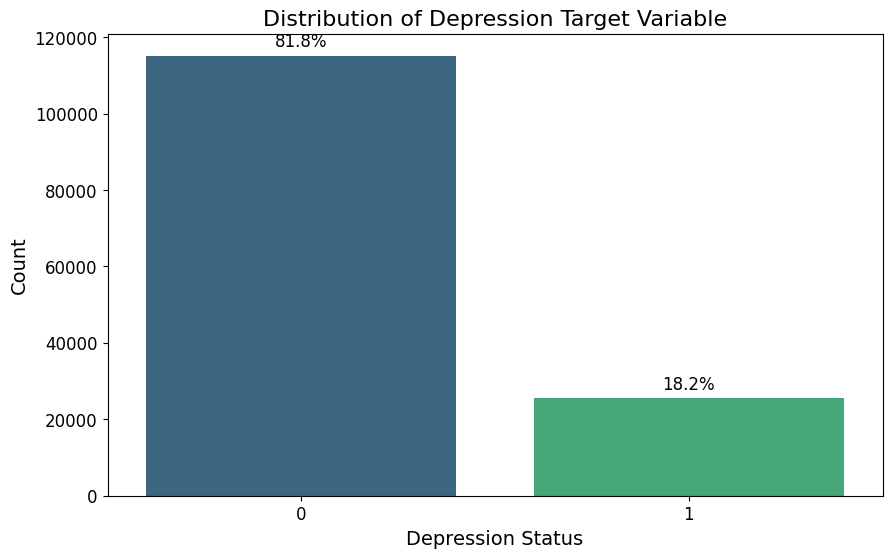

In [34]:
# Step 2.1: Data Visualizations
# Distribution of target variable
y_counts = train_df['Depression'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=y_counts.index, y=y_counts.values, palette='viridis')

# Add percentages to the bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / len(train_df))
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Distribution of Depression Target Variable', fontsize=16)
plt.xlabel('Depression Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


<ipython-input-36-48ecee995be5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=train_df, palette='viridis', order=train_df[col].value_counts().index)


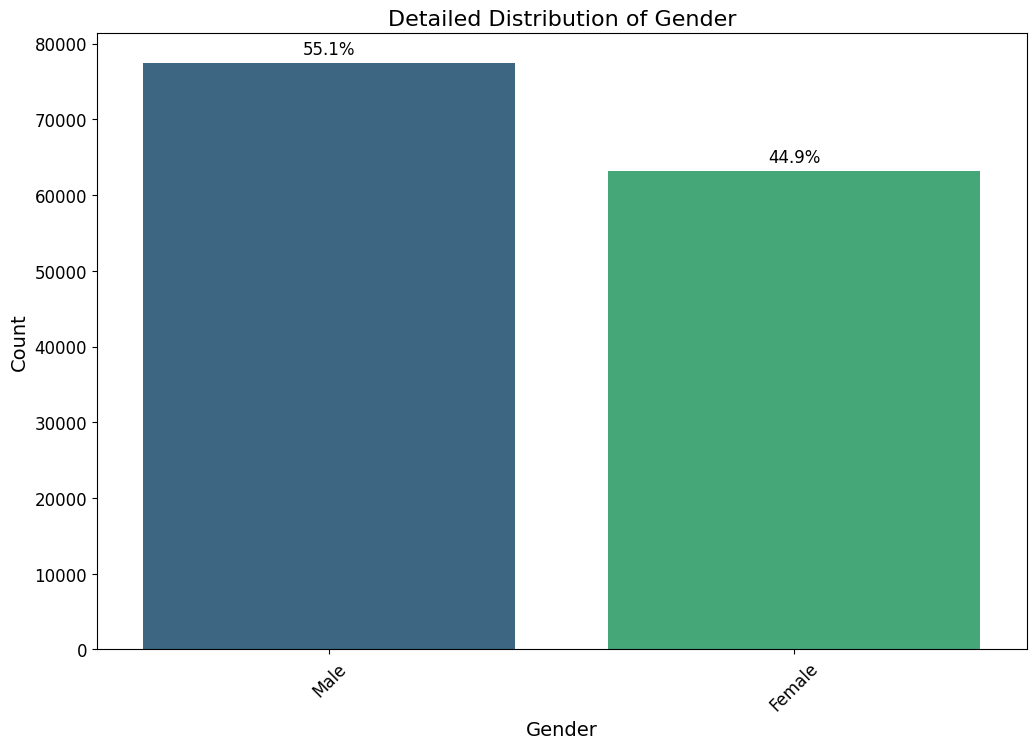

<ipython-input-36-48ecee995be5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=train_df, palette='viridis', order=train_df[col].value_counts().index)


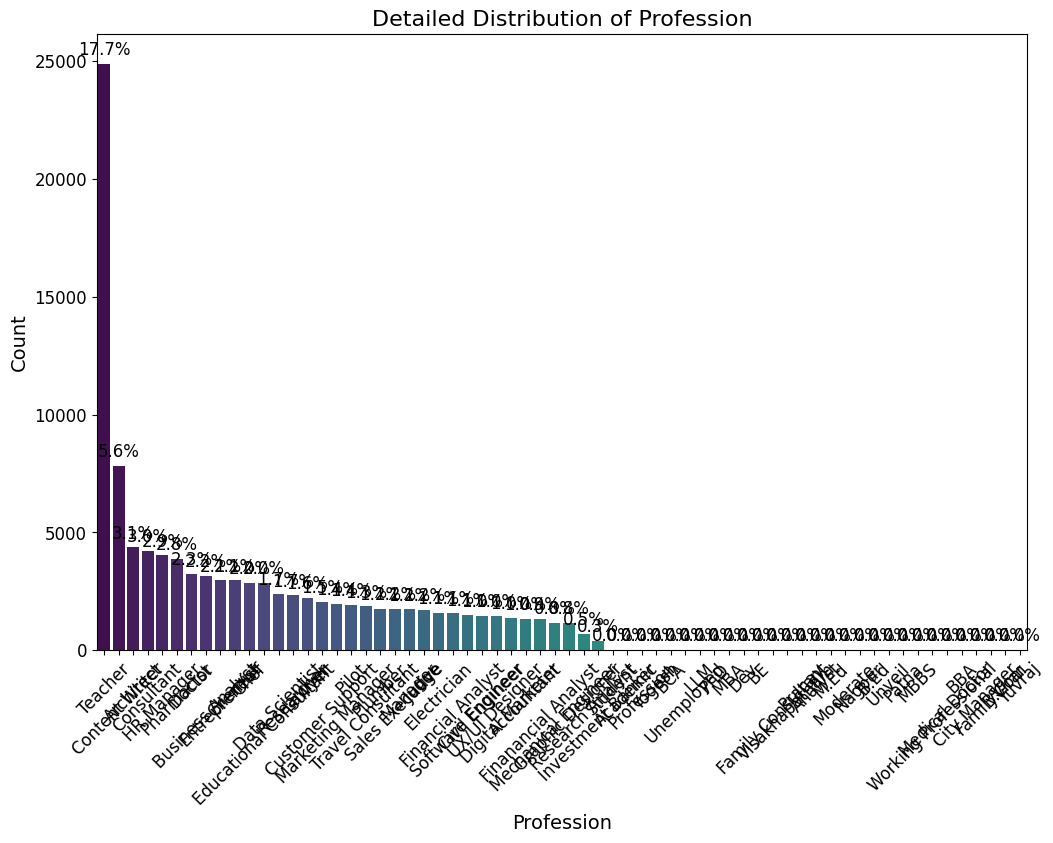

<ipython-input-36-48ecee995be5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=train_df, palette='viridis', order=train_df[col].value_counts().index)


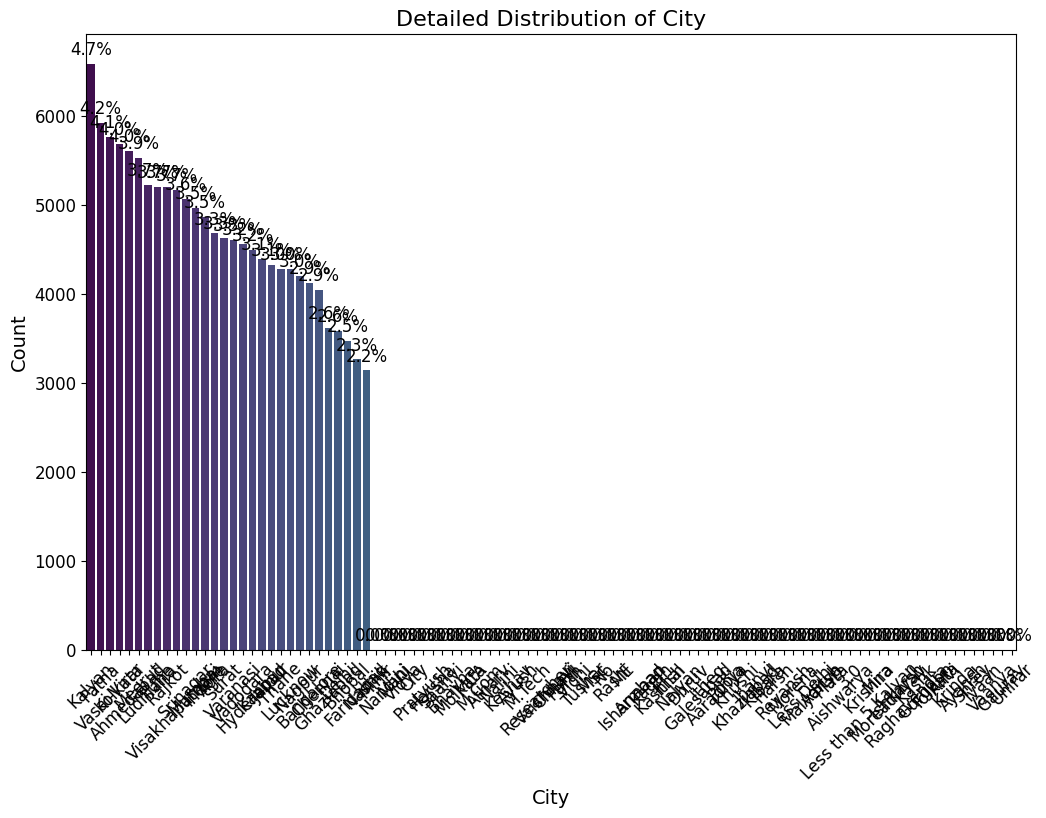

In [36]:
# Detailed distribution of categorical features with percentages
categorical_cols = ['Gender', 'Profession', 'City']
for col in categorical_cols:
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(x=col, data=train_df, palette='viridis', order=train_df[col].value_counts().index)

    # Add percentages to the bars
    total = len(train_df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                    textcoords='offset points')

    plt.title(f'Detailed Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

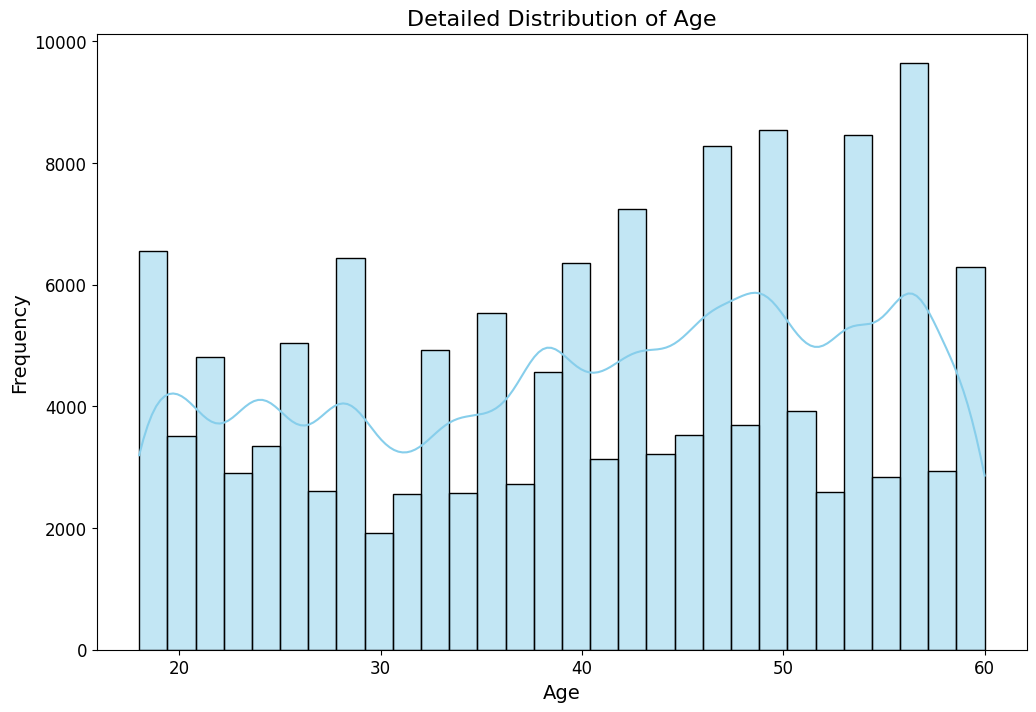

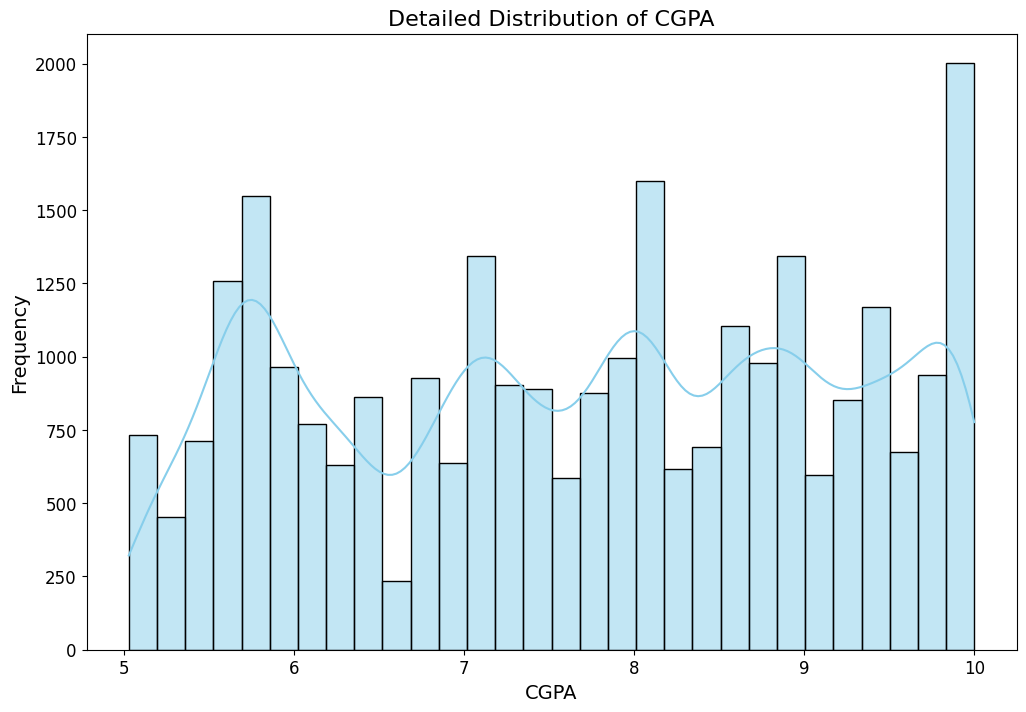

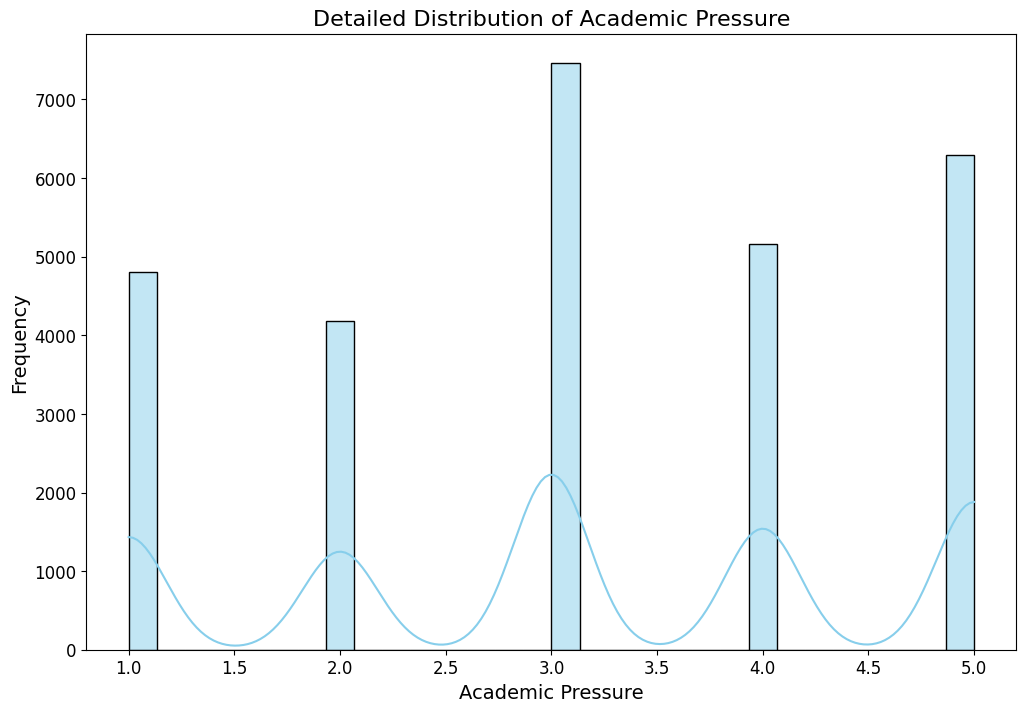

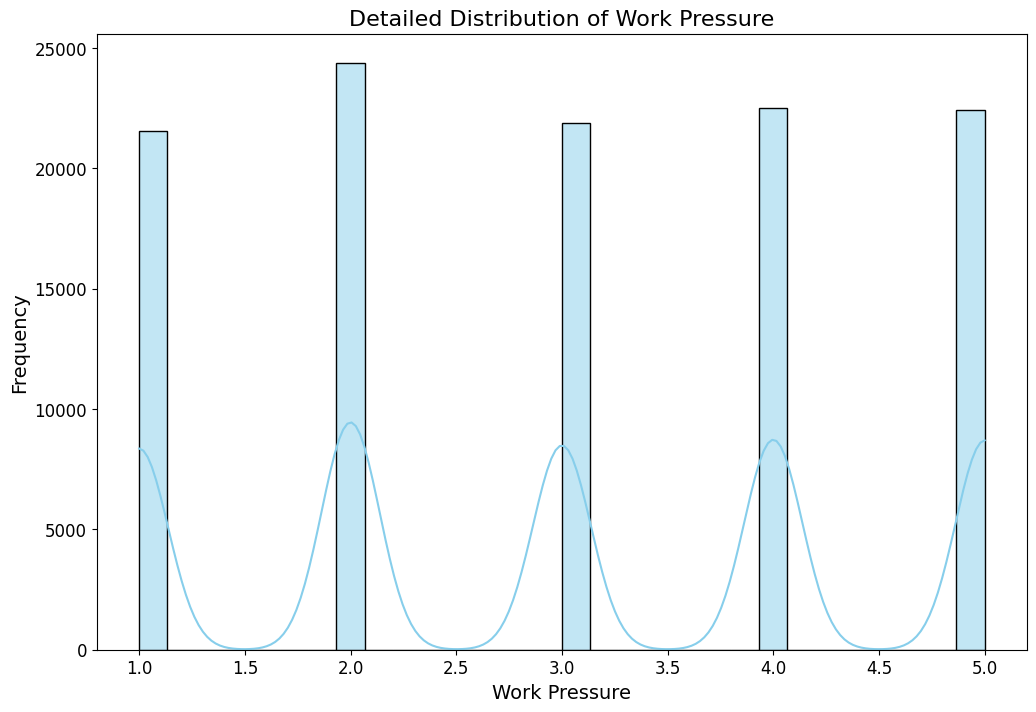

In [37]:
# Detailed distribution of numerical features
numerical_cols = ['Age', 'CGPA', 'Academic Pressure', 'Work Pressure']
for col in numerical_cols:
    plt.figure(figsize=(12, 8))
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Detailed Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

<ipython-input-38-d289032ec29a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=train_df, palette='viridis')


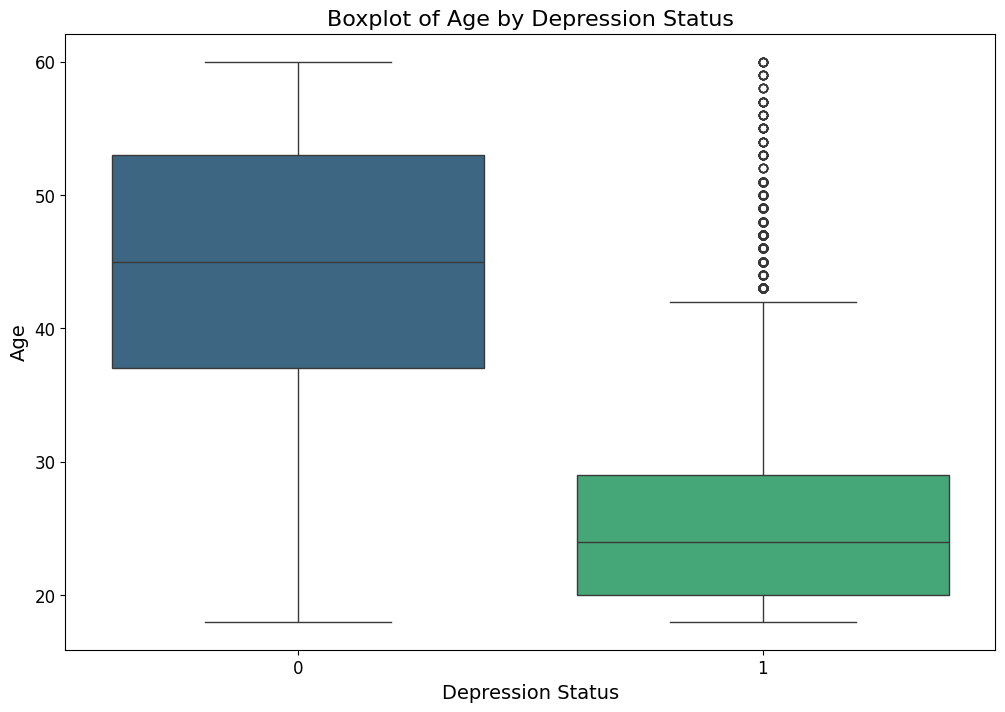

<ipython-input-38-d289032ec29a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=train_df, palette='viridis')


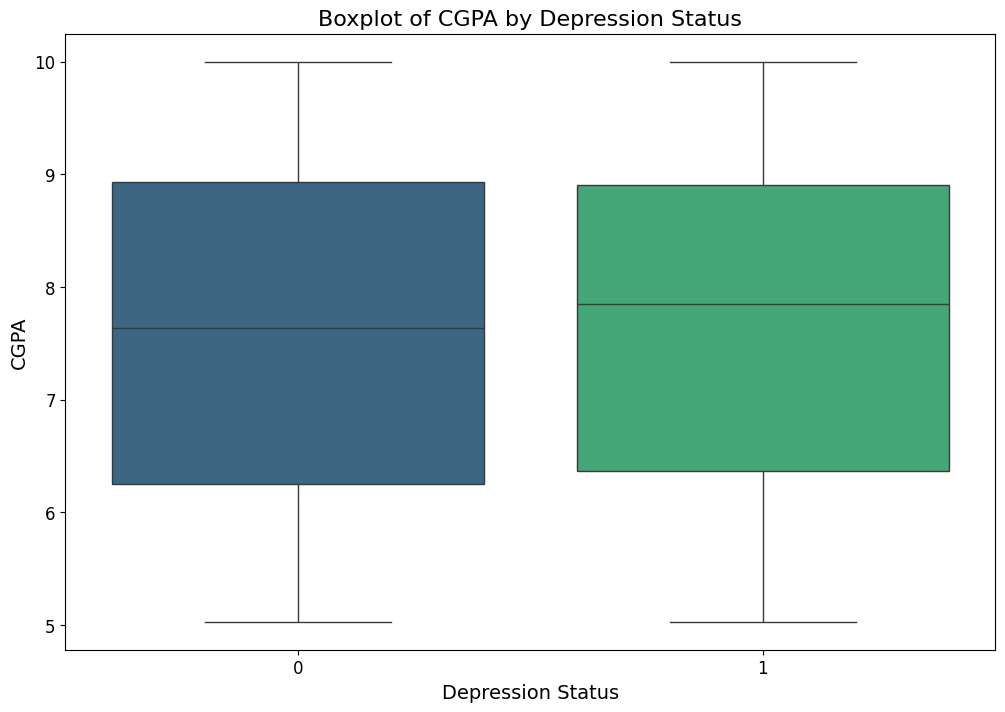

<ipython-input-38-d289032ec29a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=train_df, palette='viridis')


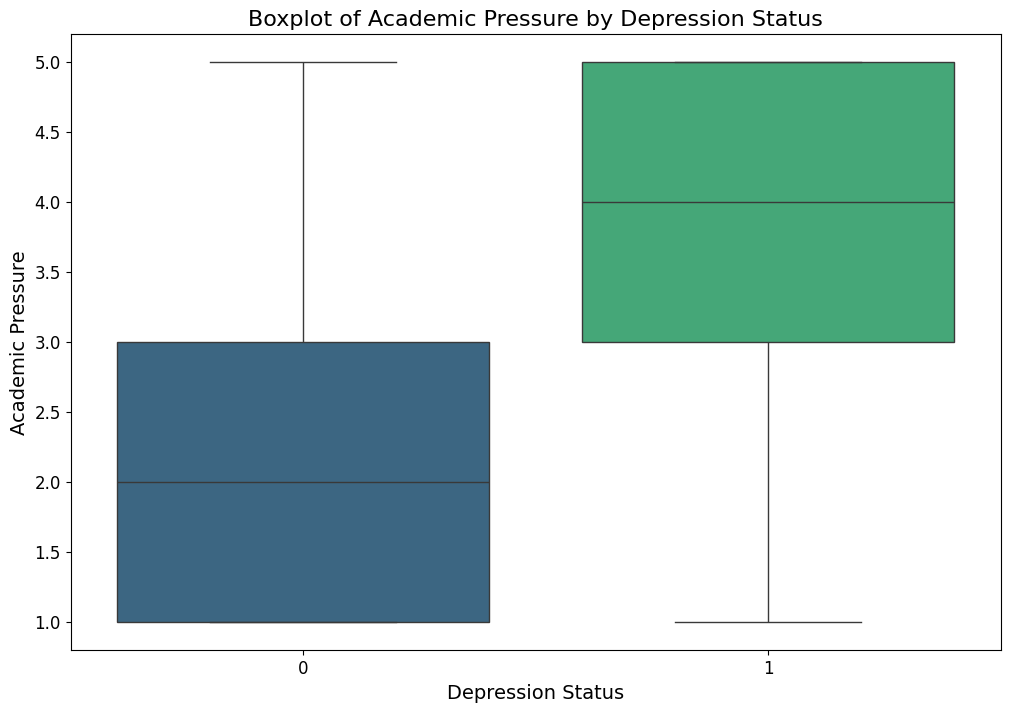

<ipython-input-38-d289032ec29a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=train_df, palette='viridis')


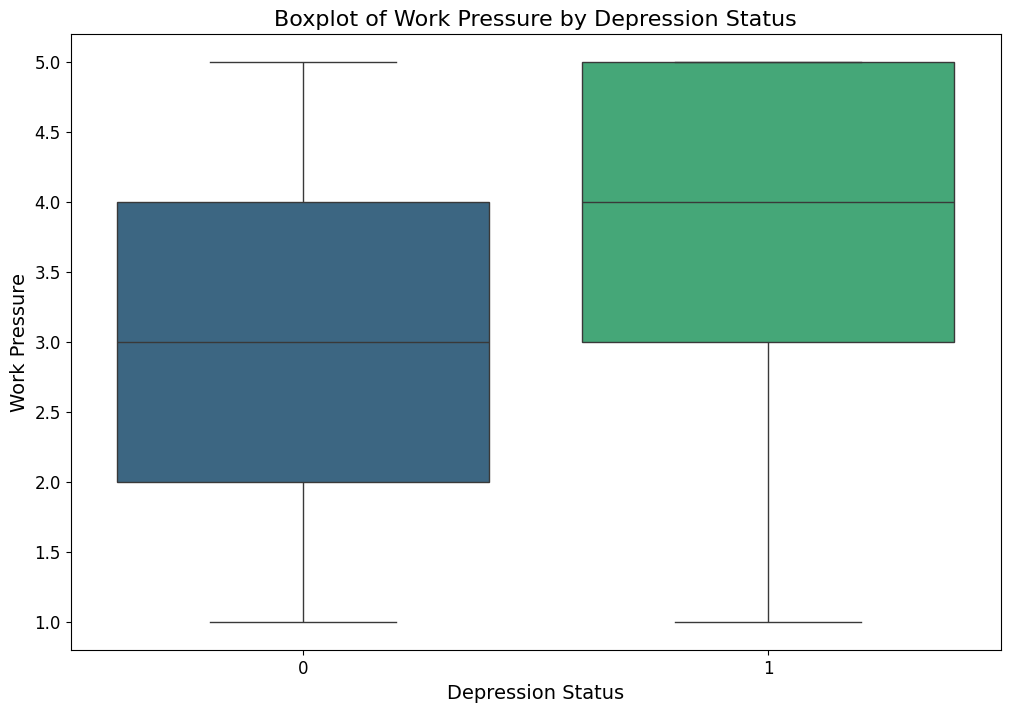

In [38]:
# Boxplots for numerical features to visualize spread and outliers
for col in numerical_cols:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Depression', y=col, data=train_df, palette='viridis')
    plt.title(f'Boxplot of {col} by Depression Status', fontsize=16)
    plt.xlabel('Depression Status', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

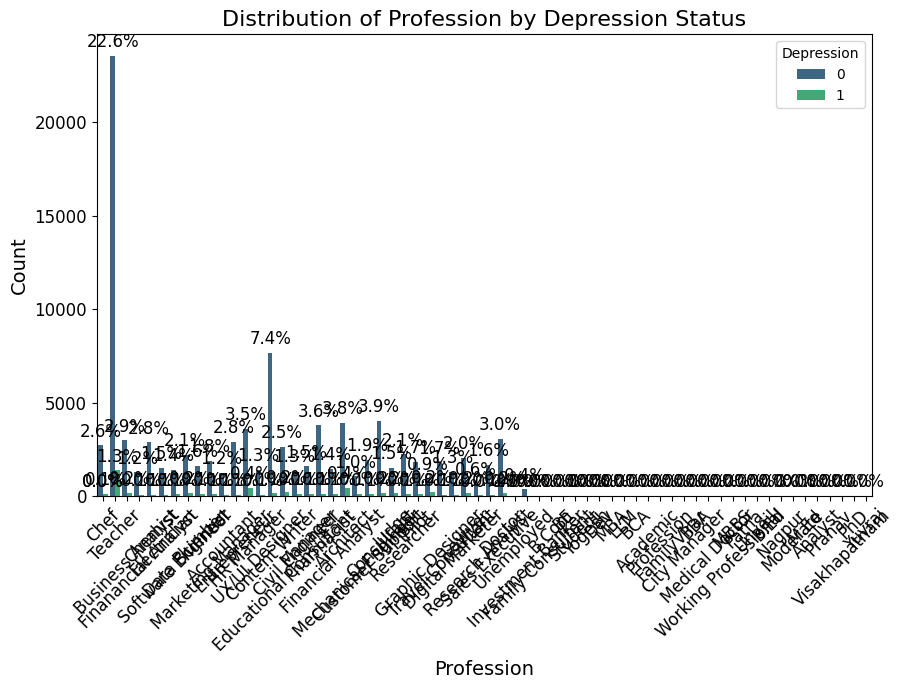

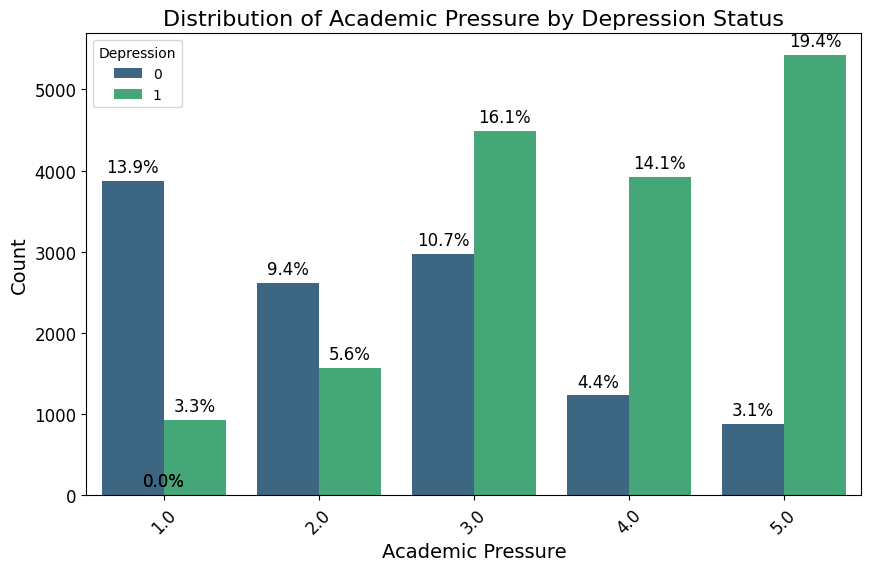

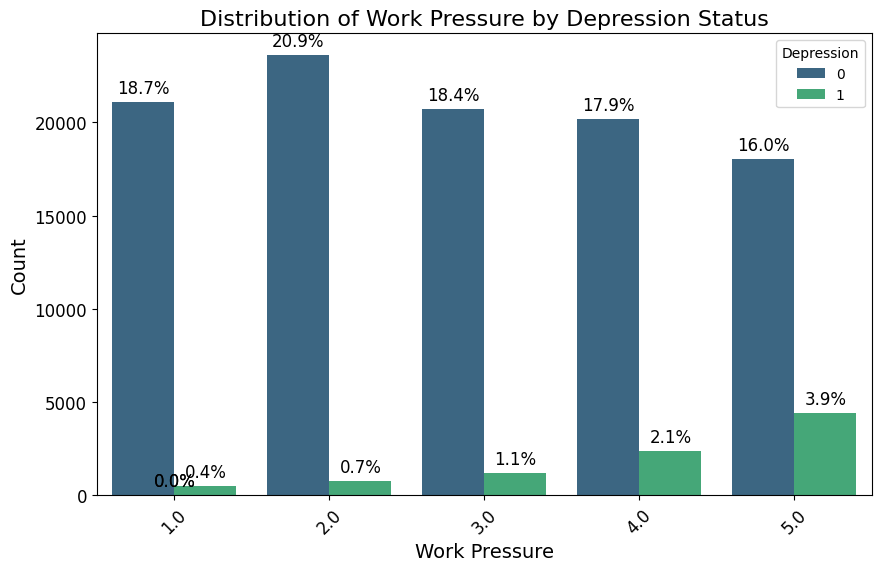

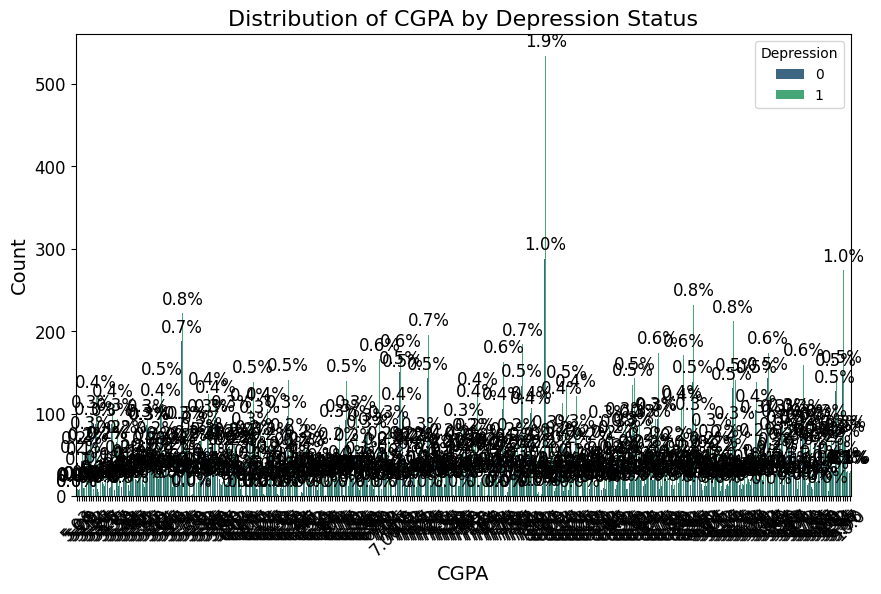

In [39]:
# Missing values visualization
missing_cols = ['Profession', 'Academic Pressure', 'Work Pressure', 'CGPA']
for col in missing_cols:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=col, hue='Depression', data=train_df, palette='viridis')

    # Add percentages to the bars
    total_counts = train_df[col].value_counts().sum()
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_counts)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                    textcoords='offset points')

    plt.title(f'Distribution of {col} by Depression Status', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [40]:
# Extracting features and target
X = train_df.drop(columns=['id', 'Depression'])  # Assuming 'Depression' is the target and 'id' is just an identifier
y = train_df['Depression']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Step 3: Data Preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test = test_df.drop(columns=['id'])  # Drop 'id' only since 'Depression' is not part of the test set
X_test_preprocessed = preprocessor.transform(X_test)

# Convert categorical NaNs to strings for CatBoost compatibility
X_train = X_train.fillna('nan')
X_val = X_val.fillna('nan')
X_test = X_test.fillna('nan')

In [47]:
# Step 4: Train a CatBoost Model
cat_features_indices = [i for i, col in enumerate(X.columns) if col in categorical_features]

catboost_model = CatBoostClassifier(
    iterations=3000,  # More iterations to allow for longer learning
    learning_rate=0.01,  # Decreased learning rate for slower and finer learning
    depth=7,  # Balanced depth for avoiding overfitting
    l2_leaf_reg=7,  # Increase regularization to reduce overfitting
    random_seed=42,
    eval_metric='Accuracy',
    od_type='Iter',
    od_wait=100,  # Increase the patience for the overfitting detector
    verbose=100,
    random_strength=2.0,  # Adds randomness to avoid overfitting
    bagging_temperature=1.0  # Adds randomization in selecting samples for training
)

catboost_model.fit(X_train, y_train, cat_features=cat_features_indices, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 0.9208955	test: 0.9206823	best: 0.9206823 (0)	total: 507ms	remaining: 25m 19s
100:	learn: 0.9322672	test: 0.9321251	best: 0.9322672 (94)	total: 25.3s	remaining: 12m 6s
200:	learn: 0.9354033	test: 0.9354655	best: 0.9355366 (195)	total: 52.1s	remaining: 12m 5s
300:	learn: 0.9373223	test: 0.9372424	best: 0.9373845 (284)	total: 1m 18s	remaining: 11m 40s
400:	learn: 0.9384861	test: 0.9378820	best: 0.9381663 (350)	total: 1m 43s	remaining: 11m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9381663113
bestIteration = 350

Shrink model to first 351 iterations.


In [48]:
# Step 5: Evaluate the Model
y_val_pred = catboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')


Validation Accuracy: 0.9382


In [49]:
# Step 6: Make Predictions on the Test Set
y_test_pred = catboost_model.predict(X_test)

# Step 7: Prepare the Submission File
test_ids = test_df['id']
submission = pd.DataFrame({'id': test_ids, 'Depression': y_test_pred})
submission.to_csv('gdrive/My Drive/playground-series-s4e11/submission5.csv', index=False)

print('Submission file created: submission5.csv')

Submission file created: submission5.csv


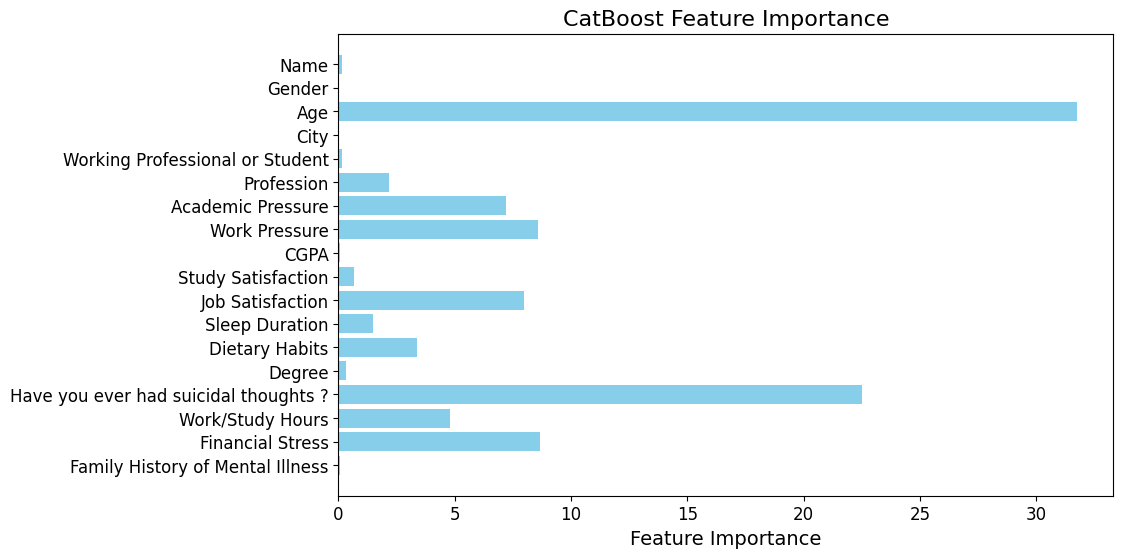

In [50]:
# Step 8: Visualize Feature Importance
feature_importances = catboost_model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.title('CatBoost Feature Importance', fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
